# Part 2e. What personal information could be revealed?

by GONG ZERUI 2022/04/22

Based on "Participant Classification by activities", we see that when participants are moving, it's easier for us to classify each individual. In this notebook, we'll try to explore whether we can reveal some personal information.

In [6]:
import warnings
warnings.filterwarnings('ignore')

### 1. Load Libraries

In [7]:
import pandas as pd
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
# To investigate distributions
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE


### 2. Load Data

In [8]:
df_train = pd.read_csv("source/train.csv")
df_test = pd.read_csv("source/test.csv")

# combine both dataframes
df_train['Data'] = 'Train'
df_test['Data'] = 'Test'
df_total = pd.concat([df_train,df_test], axis = 0).reset_index(drop = True)
df_total['subject'] = '#' + df_total['subject'].astype(str)

# create label
activity_label = df_total.pop('Activity')

print('Shape Train:\t{}'.format(df_train.shape))
print('Shape Test:\t{}\n'.format(df_test.shape))



Shape Train:	(7352, 564)
Shape Test:	(2947, 564)



### 3. Can we find the walking frequency of each participants

In this part, we used the [Singular-Spectrum Analysis notebook](https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition) (SSA) from [jdarcy](https://www.kaggle.com/jdarcy) created by [jdarcy](https://www.kaggle.com/jdarcy) SSA enables us to extract the main components of the waking style of participants using the euclidean norm of the accelerometer axes: x, y, and z.

In [9]:
# SSA Class from jdarcy
class SSA(object):    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        '''
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        '''
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError('Unsupported time series object. Try Pandas Series, NumPy array or list.')
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError('The window length must be in the interval [2, N/2].')
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = 'Re-run with save_mem=False to retain the elementary matrices.'
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = 'Re-run with save_mem=False to retain the V matrix.'
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        '''
        Returns all the time series components in a single Pandas DataFrame object.
        '''
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ['F{}'.format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        '''
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        '''
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        '''
        Calculates the w-correlation matrix for the time series.
        '''
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        '''
        Plots the w-correlation matrix for the decomposed time series.
        '''
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r'$\tilde{F}_i$')
        plt.ylabel(r'$\tilde{F}_j$')
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label('$W_{i,j}$')
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        
        

Text(0, 0.5, 'Accelerometer')

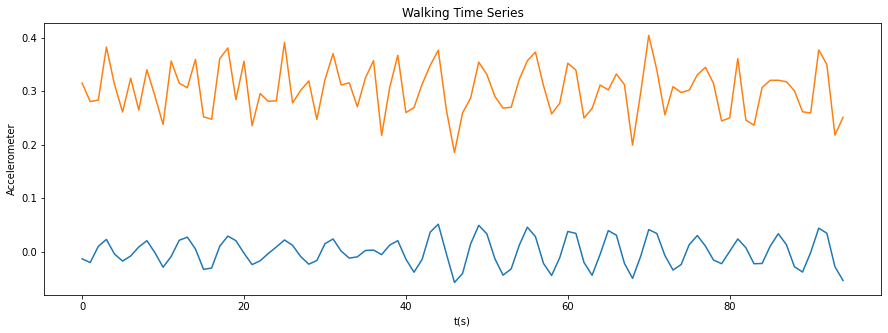

In [84]:
# Euclidean norm of the accelerometer axes
# I use participant 2 as an example
participant_id = '#1'
timeseries_walking = df_total[(activity_label == 'WALKING') & (df_total['subject'] == participant_id)][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True)
timeseries_walking = (timeseries_walking**2).sum(axis=1)**0.5


# decompose the series using SSA class
ssa_decomposed_series = SSA(timeseries_walking, 10)


# Plotting the decomposition
plt.figure(figsize=(15,5))
ssa_decomposed_series.reconstruct([1,2]).plot()
series_ssa.orig_TS.plot()
plt.title('Walking Time Series')
plt.xlabel('t(s)')
plt.ylabel('Accelerometer')


Function to fit a sin curve, credit to [unsym](https://stackoverflow.com/users/535615/unsym) from [StackOverflow](https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy).

In [19]:
# Function to fit a sin curve
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    # Assume uniform spacing
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))
    Fyy = abs(np.fft.fft(yy))
    # Exclude the zero frequency "peak"
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    # Sinus
    def sinfunc(t, A, w, p, c):  
        return A * np.sin(w*t + p) + c
    
    # Fit sinus
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}


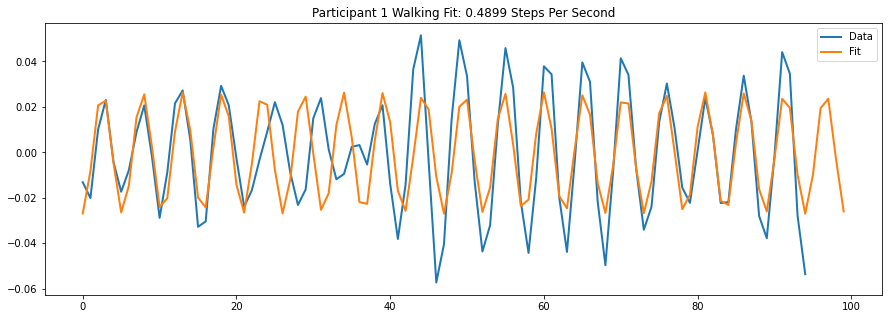

In [106]:
# Get data
walking_style = series_ssa.reconstruct([1,2])
tt = walking_style.index
yy = walking_style.values
tt_res = np.arange(0,100)
# Fit data
res = fit_sin(tt, yy)

plt.figure(figsize=(15,5))
plt.plot(tt, yy, label='Data', linewidth=2)
plt.plot(tt_res, res['fitfunc'](tt_res), label='Fit', linewidth=2)
plt.title('Participant 1 Walking Fit: {:.4f} Steps Per Second'.format((res['omega']*1.28)/(pi)))
plt.legend()



From this fitting plot it's easy to see that there's a pace change for the participant during the experiment. So it is unwise for us to fit them at the same time. Looking back to the dataset, we can see that the walking data for participant 1 are distributed in 2 different places, validating our guess.

### 4. Separating 2 different trials of experiment

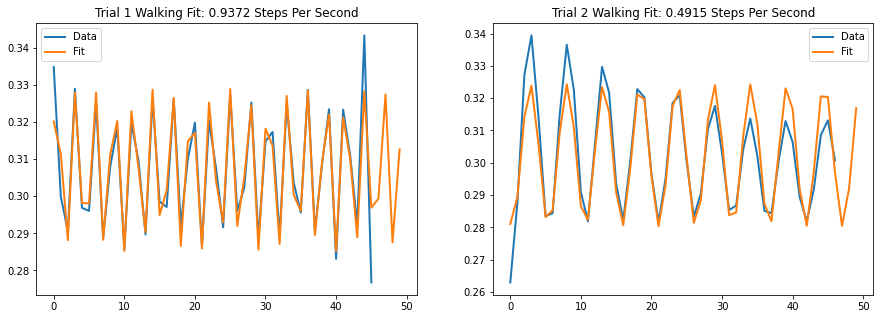

In [105]:
trial1 = df_total[78:124][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True)
trial1 = ((trial1**2).sum(axis = 1)**0.5)
trial2 = df_total[248:295][['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']].reset_index(drop=True)
trial2 = ((trial2**2).sum(axis = 1)**0.5)

trial1_ssa = SSA(trial1,20)
trial2_ssa = SSA(trial2,20)

walking_style_trial1 = trial1_ssa.reconstruct([0,1])
tt1 = walking_style_trial1.index
yy1 = walking_style_trial1.values
tt_res1 = np.arange(0,50)

walking_style_trial2 = trial2_ssa.reconstruct([0,1])
tt2 = walking_style_trial2.index
yy2 = walking_style_trial2.values
tt_res2 = np.arange(0,50)

res1 = fit_sin(tt1, yy1)
res2 = fit_sin(tt2, yy2)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(tt1, yy1, label='Data', linewidth=2)
ax[0].plot(tt_res1, res1['fitfunc'](tt_res1), label='Fit', linewidth=2)
ax[0].set_title('Trial 1 Walking Fit: {:.4f} Steps Per Second'.format((res1['omega']*1.28)/(pi)))
ax[0].legend()

ax[1].plot(tt2, yy2, label='Data', linewidth=2)
ax[1].plot(tt_res2, res2['fitfunc'](tt_res2), label='Fit', linewidth=2)
ax[1].set_title('Trial 2 Walking Fit: {:.4f} Steps Per Second'.format((res2['omega']*1.28)/(pi)))
ax[1].legend()


From this we can know that the dataset provide enough information for us to find out a person's specific walking style (steps per second)